# Stock Projection using Tweets, News Articles and Time Series

Target Companies: Facebook, Apple, Netflix

News Sources: ABC News, Business Insider, Reuters, NBC News, The New York Times, Techcrunch, Wired

In [12]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [13]:
from IPython.display import HTML
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, cross_validation
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.metrics import roc_curve, auc
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import graphviz 
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('csv/fb_netflix_apple.csv', index_col = 0)
df['company'] = df['company'].map({'Facebook': 1, 'Netflix': 2, 'Apple': 3})
df_fb = df[df['company'] ==1]
df_nf = df[df['company'] ==2]
df_ap = df[df['company'] ==3]
target = df['up_down']
X = df.loc[:, df.columns != 'up_down']
X = X.drop(['day', 'increase_decrease','movement(%)' ], axis = 1)

In [5]:
# normalize the data
def normalize(column):
    minimum = X[column].min()
    maximum = X[column].max()
    diff = maximum - minimum
    norm = (X[column] - minimum) / diff
    return norm

for column in list(X.columns):
    X[column] = normalize(column)
target = target.fillna(0)
X = X.fillna(0)

In [6]:
# tuning the weight using SMOTE
# print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
# print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

train set accuracy: 0.7983870967741935


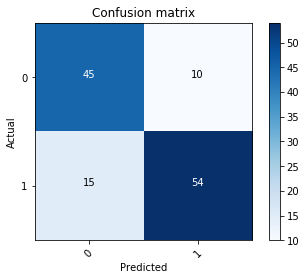

test set accuracy: 0.6190476190476191


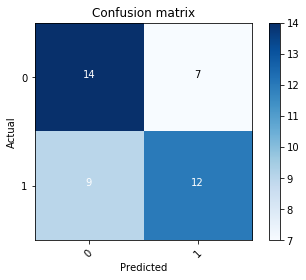

             precision    recall  f1-score   support

          0       0.61      0.67      0.64        21
          1       0.63      0.57      0.60        21

avg / total       0.62      0.62      0.62        42

0.5783132530120482
             precision    recall  f1-score   support

          0       0.64      0.57      0.60        93
          1       0.52      0.59      0.55        73

avg / total       0.59      0.58      0.58       166



In [7]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm,  cmap) #Create the basic matrix.
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()
    
def test_set(X, Y) :
    data_train, data_test, target_train, target_test = train_test_split(X, Y)
    logreg = LogisticRegression()
    logreg.fit(data_train, target_train)
    predict_train = logreg.predict(data_train)
    predict_test = logreg.predict(data_test)
    cnf_matrix_train = confusion_matrix(predict_train, target_train)
    cnf_matrix_test = confusion_matrix(predict_test, target_test)
    print('train set accuracy: ' + str(metrics.accuracy_score(predict_train, target_train)))
    plot_confusion_matrix(cnf_matrix_train, classes = set(y_resampled))
    print('test set accuracy: ' + str(metrics.accuracy_score(predict_test, target_test)))
    plot_confusion_matrix(cnf_matrix_test, classes = set(y_resampled))
    print(metrics.classification_report(predict_test, target_test))
    
test_set(X_resampled, y_resampled)

## cross validation
def k_fold(X, Y, cv = 3):
    predicted = cross_validation.cross_val_predict(LogisticRegression(), X, Y, cv=cv)
    print(metrics.accuracy_score(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))
    print(metrics.classification_report(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))

k_fold(X_resampled, y_resampled, cv = 10)

AUC for L1: 0.5354691075514875
AUC for L2: 0.5377574370709381


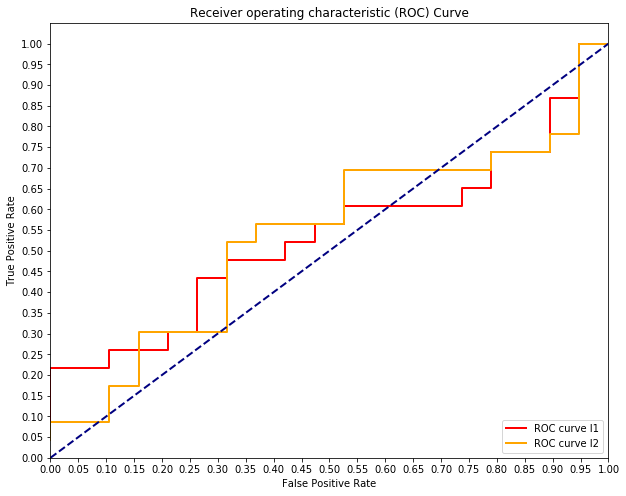

In [8]:
# LASSO Ridge
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
area = []
for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, penalty=pen) #Starter code
    model_log = logreg.fit(data_train, target_train)
#     print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(data_test)

    y_score = logreg.fit(data_train, target_train).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, y_score)
    
    print('AUC for {}: {}'.format(str(pen.upper()), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
    area.append(auc(fpr, tpr))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
def correlation_heatmap(df, title = 'heatmap'):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = []
    for column in list(df.columns):
        correlation = df['up_down'].corr(df[column])
        corr.append(correlation)
    corrs = pd.Series(corr).to_frame().transpose()
    corrs.columns = df.columns
    corrs = corrs.set_index('up_down')
    f, ax = plt.subplots(figsize=(18, 3))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = plt.axes()
    sns.heatmap(corrs,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
    ax.set_title(title)
    plt.show()
    
# Twitter heatmap
twitter_heatmap = pd.concat([X_tweets_new, df['up_down']], axis =1)
correlation_heatmap(twitter_heatmap, title = 'Heatmap - Tweets vs. Stock Price')

# all news heatmap
X_news = X.loc[:, 'day compound avg':]
X_news = X_news.drop(['company'], axis = 1)
news_heabtmap = pd.concat([X_news, df['up_down']], axis =1)
correlation_heatmap(news_heabtmap, title = 'Heatmap - News Articles vs. Stock Price')

X_tweets = X.loc[:,'sentiment_avg_30':'count_pos, morning']
X_tweets_new = X_tweets
X_tweets_new["total_count_30"] = X_tweets_new['coun_neg, 30'] + X_tweets_new['coun_neu, 30'] + X_tweets_new['coun_pos, 30']
X_tweets_new["total_count_60"] = X_tweets_new['coun_neg, 60'] + X_tweets_new['coun_neu, 60'] + X_tweets_new['coun_pos, 60']
X_tweets_new["total_count_120"] = X_tweets_new['coun_neg, 120'] + X_tweets_new['coun_neu, 120'] + X_tweets_new['coun_pos, 120']
X_tweets_new["total_count_night_before"] = X_tweets_new['count_neg, night_before'] + X_tweets_new['count_neu, night_before'] + X_tweets_new['count_pos, night_before']
X_tweets_new["total_count_morning"] = X_tweets_new['count_neg, morning'] + X_tweets_new['count_neu, morning'] + X_tweets_new['count_pos, morning']

X_tweets_new = X_tweets_new.drop(['coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30', 'coun_neg, 60', 'coun_neu, 60', 
                                  'coun_pos, 60', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120', 'count_neg, night_before', 
                                  'count_neu, night_before', 'count_pos, night_before','count_neg, morning','count_neu, morning', 'count_pos, morning'], axis =1)

compound_list = [source for source in X_news.columns if 'compound' in source]
compound_news = X_news[compound_list]
compound_news = compound_news[['day compound avg',
                         'two day compound avg',
                         'one day the-new-york-times compound avg',
                         'two day the-new-york-times compound avg',
                         'one day reuters compound avg',
                         'two day reuters compound avg',
                         'one day business-insider compound avg',
                         'two day business-insider compound avg',
                         'one day techcrunch compound avg',
                         'two day techcrunch compound avg',
                         'one day wired compound avg',
                         'two day wired compound avg',
                         'one day nbc-news compound avg',
                         'two day nbc-news compound avg',
                         'one day abc-news compound avg',
                         'two day abc-news compound avg',
                         ]]
news_compound_heabtmap = pd.concat([compound_news, df['up_down']], axis =1)
correlation_heatmap(news_compound_heabtmap, title = 'Heatmap - News Articles by Sources vs. Stock Price')

NameError: name 'X_tweets_new' is not defined